Fluorescent Powder 
====================================================

### Authors: MFK, MLG, YL, AMW

We try to fit the recurrence relationship to the data


In [2]:
# install if not done yet
%pip install pyabc --quiet

In [2]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

import pyabc as pyabc
from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon, QuantileEpsilon, AdaptivePNormDistance
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "yi_data.db")

1.0 Data
----

We use a data set which consists of a vector of n contact points $n$
and a measurement vector 'RawIntD' which is the raw luminescence value for each $n_i$.  


In [3]:
data = pd.read_csv('../data/Yi.data.longformat.20191121_censoring_handled.csv', sep=',',header=0)

# create RelavitiveIntD column by dividing RawIntD by the PowderArea column
data['RelIntD'] = data['RawIntD'] / data['PowderArea']
data = data[data['Date'].isin(['05/07/2019', '09/07/2019', '10/07/2019', '07/18/2019','07/19/2019','07/22/2019'])]
#subset data to filter Surface == Plastic & Gloves == Y, and then take the mean and std of the concentration for each ContactNumber
measurement_data = data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RawIntD'].median()
# normalise measurement_data bewteen 0 and 1
#measurement_data = (measurement_data - measurement_data.min()) / (measurement_data.max() - measurement_data.min())
#measurement_data = measurement_data / measurement_data.max()

s = data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RawIntD'].std()
measurement_data,s

measurement_times = np.linspace(1, 5, 5) 

(ContactNumber
 1    5564219.5
 2    4167148.5
 3    3704789.5
 4    3575570.0
 5    2537228.5
 Name: RawIntD, dtype: float64,
 ContactNumber
 1    3.076967e+06
 2    2.401514e+06
 3    1.976640e+06
 4    1.988425e+06
 5    1.881077e+06
 Name: RawIntD, dtype: float64)

### 1.01 Summary of the Data

In [62]:
data.describe()

,RawIntD,LoadingWeight,ContactNumber,ID,PowderArea,RelIntD
count,2.520000e+03,2514.000000,2520.000000,2520.000000,2520.000000,2.520000e+03
mean,6.227286e+06,102.394321,3.000000,43.047619,50.010102,1.318763e+05
std,4.313066e+06,80.608008,1.414494,24.947219,26.591880,1.019275e+05
min,6.997700e+04,0.352000,1.000000,1.000000,0.881000,6.916033e+03
25%,3.368425e+06,36.981625,2.000000,21.750000,30.255250,8.990277e+04
50%,5.265410e+06,81.746800,3.000000,42.500000,46.708500,1.025679e+05
75%,7.908371e+06,154.166500,4.000000,65.250000,65.610500,1.904805e+05
max,3.451602e+07,299.172773,5.000000,86.000000,174.678000,4.091358e+06


# 2. Visuals

Let's plot the mean and error bars for each of the experimental categories: 
- Gloves (Y/N)
- Surface type (Glass/Plastic/Cloth)


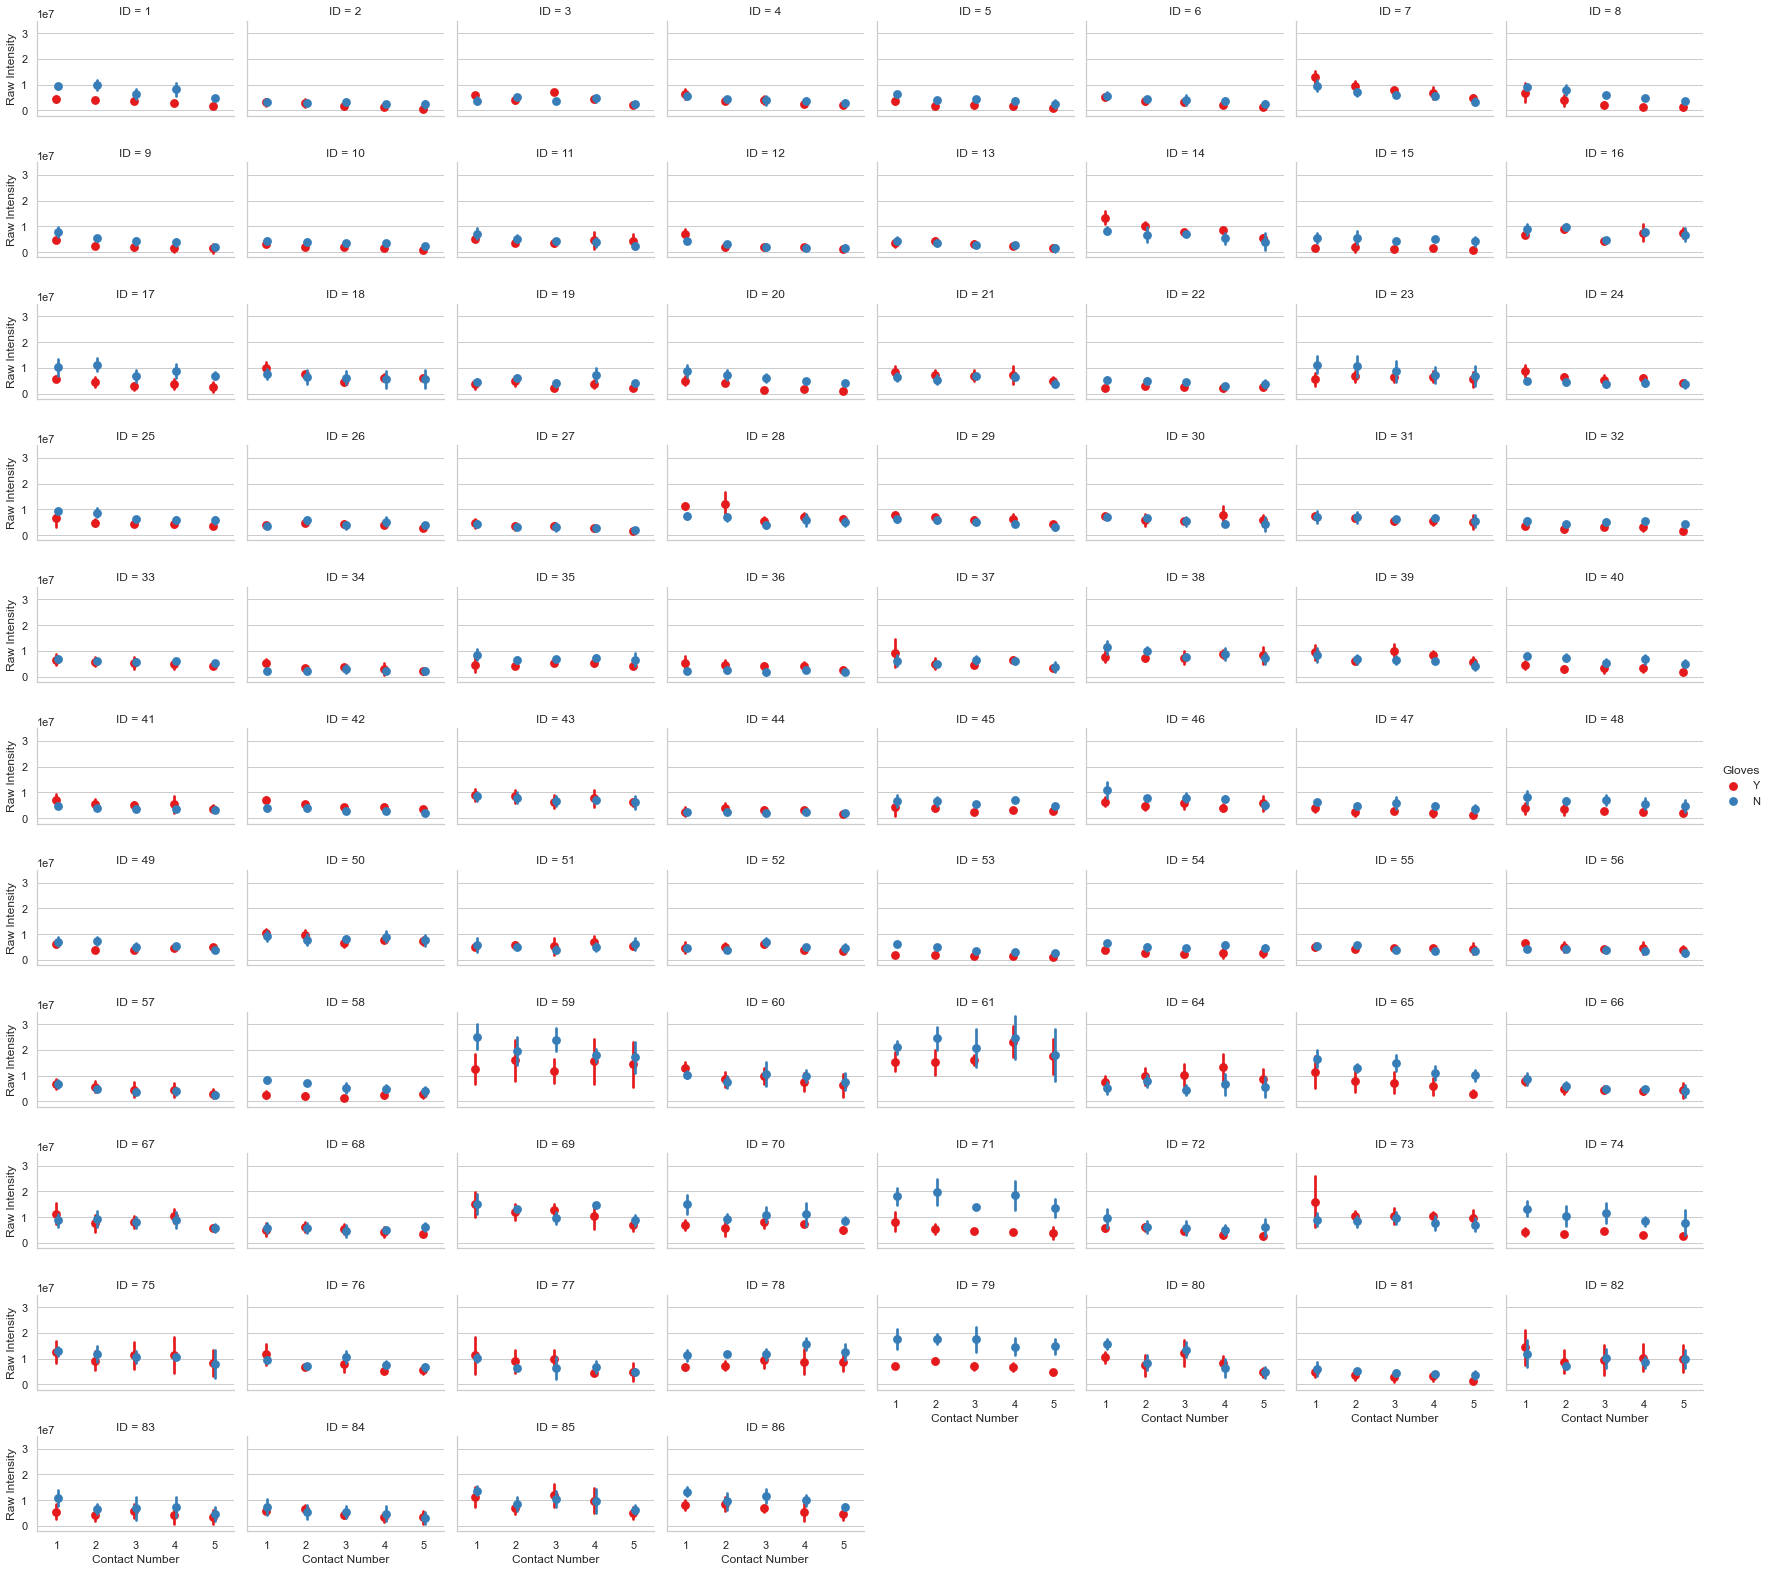

In [22]:
# Seaborn for plotting 40 IDs

# Use seaborn to plot the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
import seaborn as sns
sns.set(style="whitegrid")
# use catplot to plot the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
g=sns.catplot(x='ContactNumber', y='RawIntD', hue='Gloves', col='ID', data=data, kind='point', ci='sd', dodge=True, join=False, palette='Set1', col_wrap=8, height=2, aspect=1.5)
g.set_axis_labels('Contact Number', 'Raw Intensity')
#g.refline(y=data["RawIntD"].median())
plt.show()

### 2.1 Plot by date

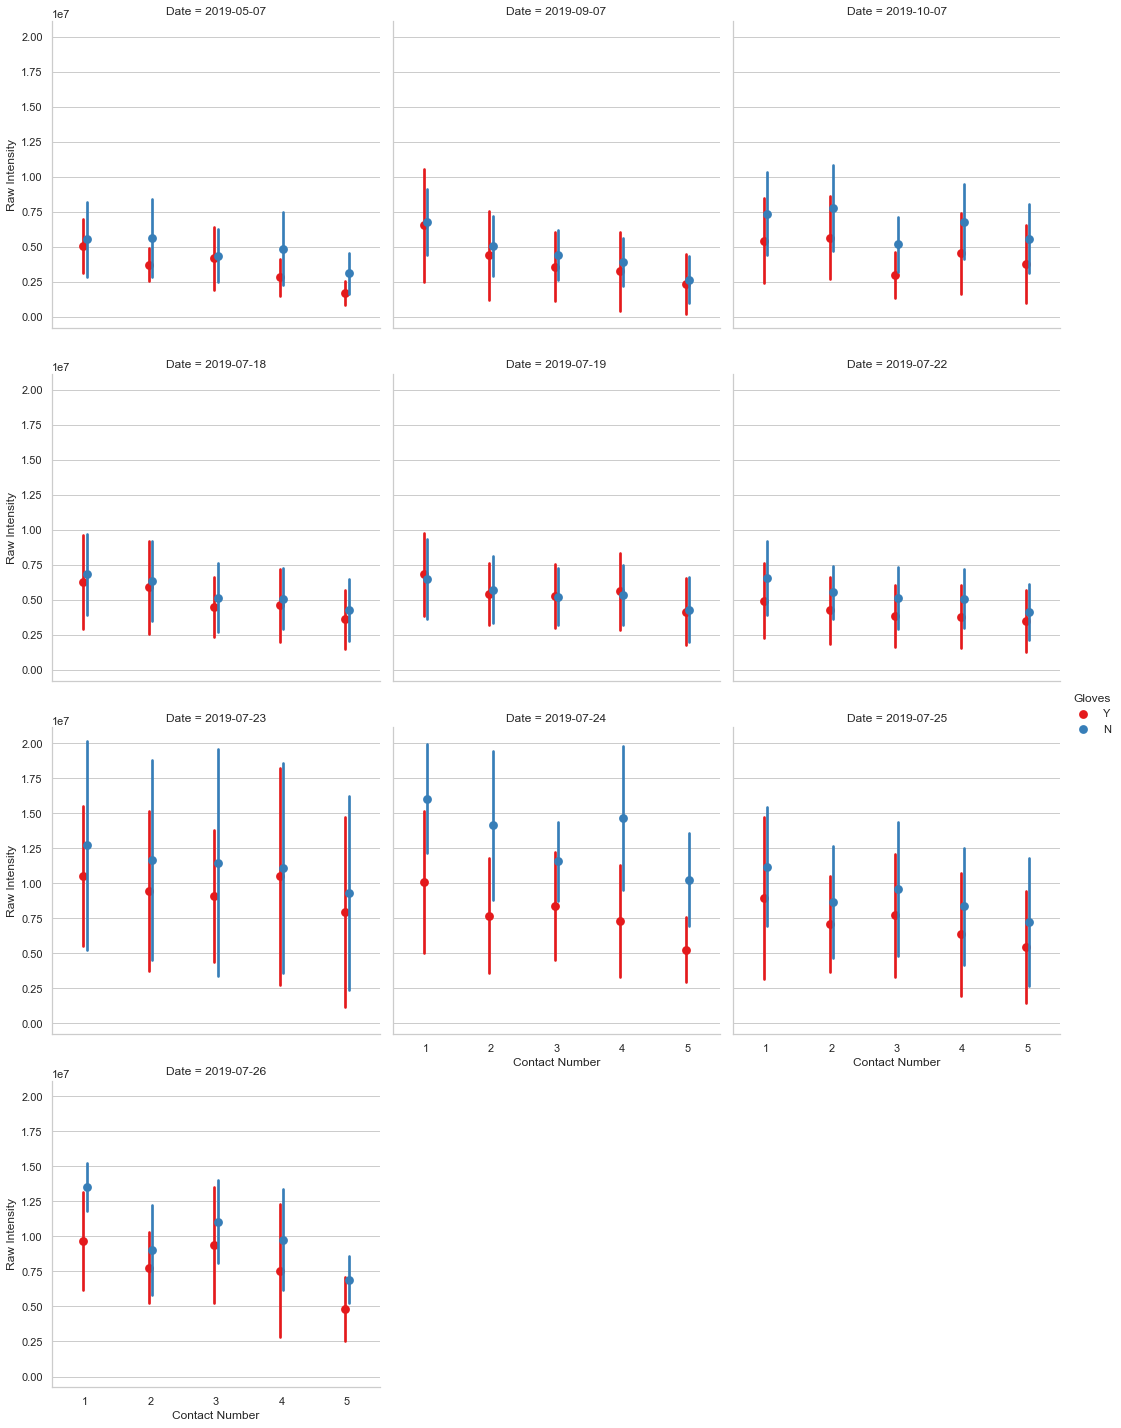

In [33]:
#Fix dates because 07/18/2019 to 07/26/2019 should be 18/07/2019 to 07/26/2019 
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
#remove T00:00:00.0000000000 from Date
data['Date'] = data['Date'].dt.date
# Plot ContactNumber vs RawIntD for each Surface and Gloves combination and facet by date
g=sns.catplot(x='ContactNumber', y='RawIntD', hue='Gloves', col='Date',data=data, kind='point', ci='sd',col_wrap=3, dodge=True, join=False, palette='Set1')
g.set_axis_labels('Contact Number', 'Raw Intensity')



### 2.2 Means and Standard deviations

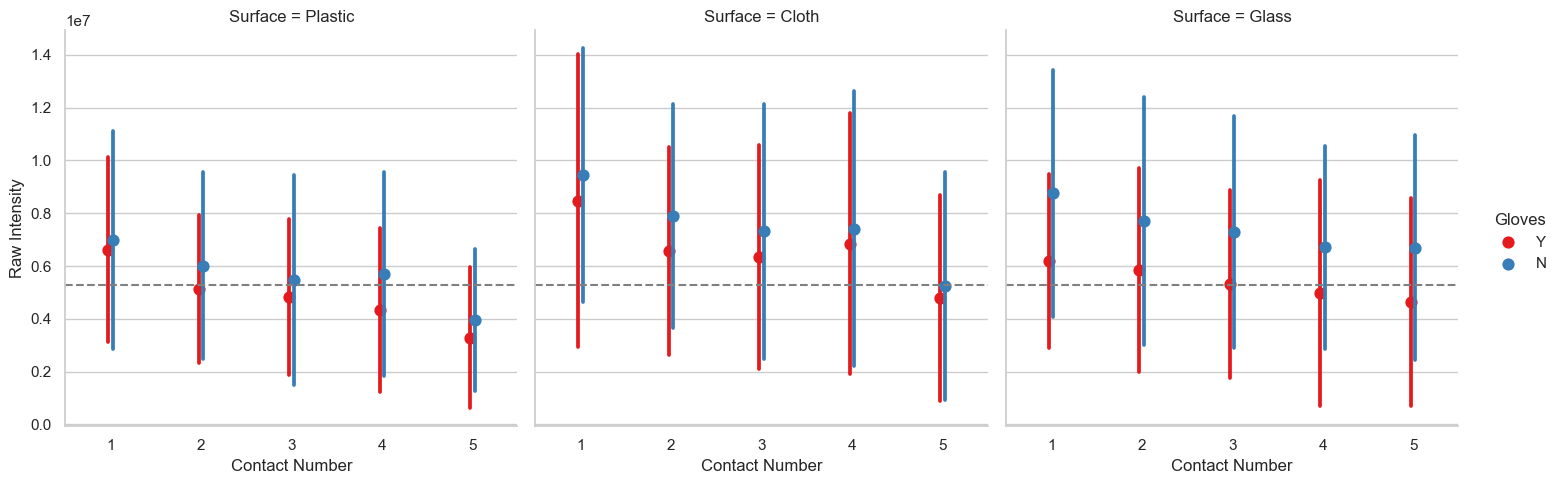

In [83]:
# plot RawIntD for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph

"""Plotting the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
fig, ax = plt.subplots()
ax.errorbar(data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RawIntD'].mean().index,
            data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RawIntD'].mean(),
            yerr=data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RawIntD'].std(),
            fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
# add dodge between the two error bars
ax.set_xlim(0, 6)
ax.set_xlabel('Contact Number')
ax.set_ylabel('Relative Intensity')
ax.set_title('Relative Intensity (Intesity/Area) for Plastic Surface with Gloves')
plt.show()

# plot RawIntD for each ContactNumber for Plastic and N gloves with error bars
fig, ax = plt.subplots()
ax.errorbar(data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N')].groupby('ContactNumber')['RawIntD'].mean().index,
            data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N')].groupby('ContactNumber')['RawIntD'].mean(),
            yerr=data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N')].groupby('ContactNumber')['RawIntD'].std(),
            fmt='s', color='black', ecolor='lightblue', elinewidth=3, capsize=0)
# add dodge between the two error bars
ax.set_xlim(0, 6)
ax.set_xlabel('Contact Number')
ax.set_ylabel('Relative Intensity')
ax.set_title('Relative Intensity (Intesity/Area) for Plastic Surface without Gloves')
plt.show()
"""

# Use seaborn to plot the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
import seaborn as sns
sns.set(style="whitegrid")
# use catplot to plot the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
g=sns.catplot(x='ContactNumber', y='RawIntD', hue='Gloves', col='Surface', data=data, kind='point', ci='sd', dodge=True, join=False, palette='Set1')
g.set_axis_labels('Contact Number', 'Raw Intensity')
g.refline(y=data["RawIntD"].median())
plt.show()

Same plots but for PowderArea vs Contact number

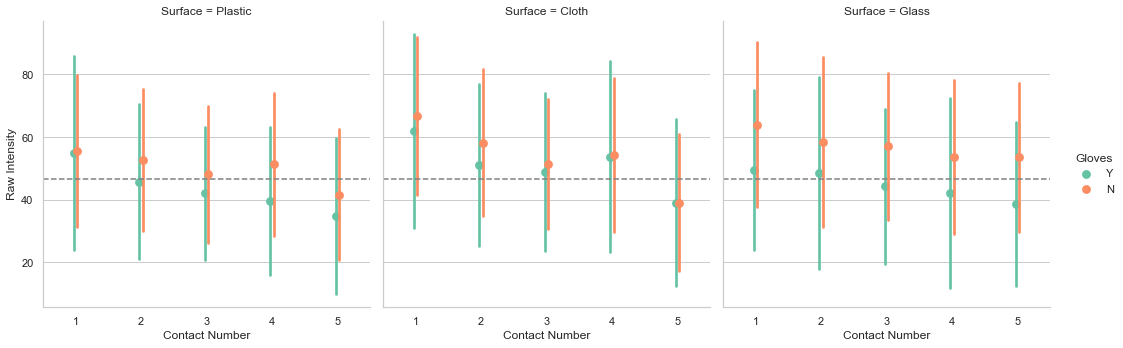

In [9]:
# Use seaborn to plot the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
import seaborn as sns
sns.set(style="whitegrid")
# use catplot to plot the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
g=sns.catplot(x='ContactNumber', y='PowderArea', hue='Gloves', col='Surface', data=data, kind='point', ci='sd', dodge=True, join=False, palette='Set2')
g.set_axis_labels('Contact Number', 'Raw Intensity')
g.refline(y=data["PowderArea"].median())
plt.show()

# RawIntD divided by PowderArea : RelIntD

Let's plot some historgrams of the powder area and calculate summary statistics by surface

,count,mean,std,min,25%,50%,75%,max
Surface,,,,,,,,
Cloth,840.0,52.448155,27.044600,3.136,32.33625,48.6770,69.8235,158.847
Glass,840.0,50.944058,27.451723,2.384,29.24750,47.3355,67.9390,174.678
Plastic,840.0,46.638092,24.896866,0.881,29.13225,44.4355,60.5795,154.574


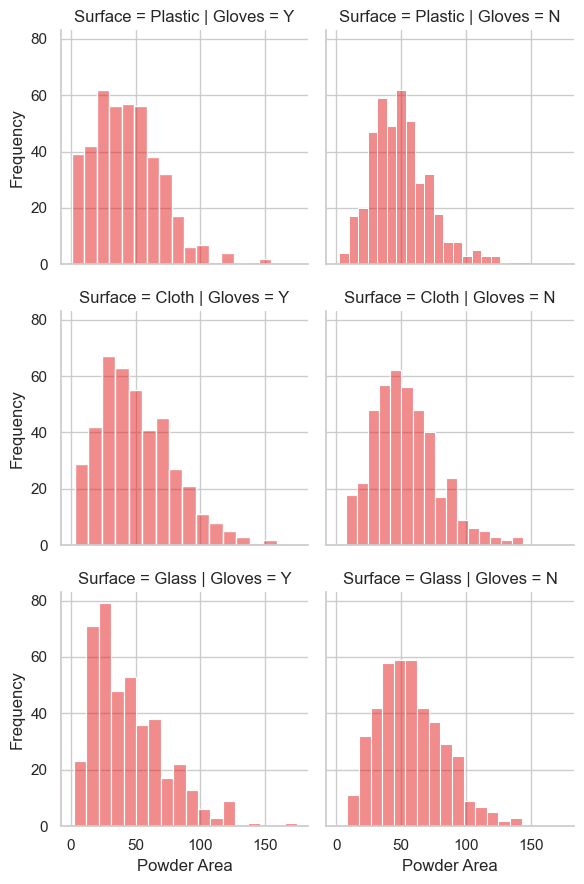

In [97]:
sns.set(style="whitegrid")
# use catplot to plot the data for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph
#g=sns.catplot(x='PowderArea',  hue='Gloves', col='Surface', data=data, kind='histogram', join=False, palette='Set1')

g = sns.FacetGrid(data, col="Gloves", row="Surface")
g.map_dataframe(sns.histplot, x="PowderArea", hue='Gloves', palette='Set1')
g.set_axis_labels('Powder Area', 'Frequency')

# summary statistics of PowderArea for each Surface
data.groupby('Surface')['PowderArea'].describe()



# 3.0 Estimating the finger area f_a from p_a
Yi Lui extracted 30 participant's real contact area using ImageJ so we want ot find a relationship between that and the powder area measured for all the participants. We will use the min and max Surface Area to as starting values for the finger area in the ABC algorithm.


In [33]:
# Import the sub-sampled data from Sheet 2
sub_df = pd.read_csv('../data/30_subsample.csv', sep=',',header=0)
sub_df.describe() 

,PowderArea,SurfaceArea,LoadingWeight,ID,ContactNumber
count,150.000000,150.00000,150.000000,150.000000,150.000000
mean,54.146427,113.52976,90.859431,15.500000,3.000000
std,22.853791,37.85614,59.193877,8.684438,1.418951
min,8.433000,34.86200,6.009700,1.000000,1.000000
25%,37.587000,85.47325,43.920025,8.000000,2.000000
50%,51.980000,105.97250,80.470900,15.500000,3.000000
75%,65.517500,132.87075,127.486125,23.000000,4.000000
max,129.052000,217.09000,220.000000,30.000000,5.000000


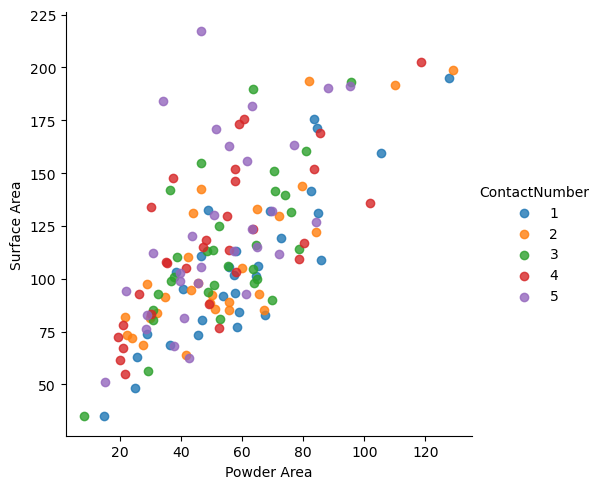

                            OLS Regression Results                            
Dep. Variable:        log_SurfaceArea   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     174.3
Date:                Tue, 03 Jan 2023   Prob (F-statistic):           8.60e-27
Time:                        13:50:17   Log-Likelihood:                 6.7463
No. Observations:                 150   AIC:                            -9.493
Df Residuals:                     148   BIC:                            -3.471
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5397      0.163     15.

In [41]:

# plot PowderArea vs SurfaceArea and colour points by ContactNumber using seaborn
import seaborn as sns
sns.lmplot(x='PowderArea', y='SurfaceArea', data=sub_df, hue='ContactNumber', fit_reg=False)
plt.xlabel('Powder Area')
plt.ylabel('Surface Area')
plt.show()

# run a linear regression on the data to assess whether contact number has an effect on the surface area. Transform the data to log scale
import statsmodels.api as sm
import statsmodels.formula.api as smf
# transform the data to log scale
sub_df['log_PowderArea'] = np.log(sub_df['PowderArea'])
sub_df['log_SurfaceArea'] = np.log(sub_df['SurfaceArea'])
# run a linear regression on the data and force the intercept to be 0
model = smf.ols(formula='log_SurfaceArea ~ log_PowderArea ', data=sub_df)
results = model.fit()
print(results.summary())


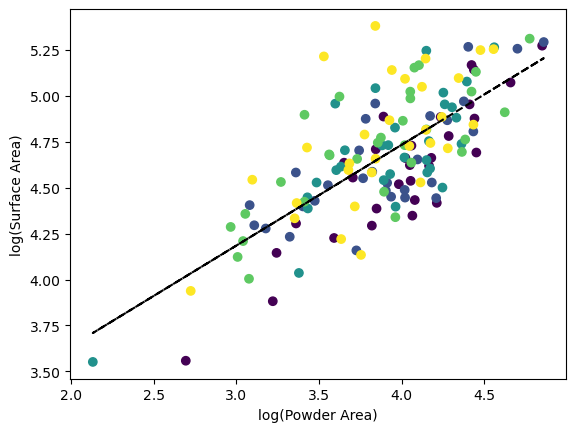

In [49]:
# plot the data and the regression line
fig, ax = plt.subplots()
ax.scatter(sub_df['log_PowderArea'], sub_df['log_SurfaceArea'], c=sub_df['ContactNumber'], cmap='viridis')
ax.plot(sub_df['log_PowderArea'], results.fittedvalues, 'k--')
ax.set_xlabel('log(Powder Area)')
ax.set_ylabel('log(Surface Area)')
plt.show()


We notice that the variace increases as the PowderArea increaseses so instead of a linear relationship we use a log relationship.

In [44]:
sub_df.columns


sub_df['intercept'] = 1
sub_df.head()
# create a GLM between PowderArea and SurfaceArea using Poisson distribution and log link function
import statsmodels.api as sm
from statsmodels.formula.api import glm
# Fit the model
model = sm.GLM(sub_df['SurfaceArea'], sub_df[['intercept', 'PowderArea']], family=sm.families.Gaussian(link=sm.families.links.log()))
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            SurfaceArea   No. Observations:                  150
Model:                            GLM   Df Residuals:                      148
Model Family:                Gaussian   Df Model:                            1
Link Function:                    log   Scale:                          764.80
Method:                          IRLS   Log-Likelihood:                -709.81
Date:                Tue, 03 Jan 2023   Deviance:                   1.1319e+05
Time:                        13:53:34   Pearson chi2:                 1.13e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5830
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2260      0.052     81.728      0.0

If we wanted we could predict the finger area from the powder area using the following relationship:

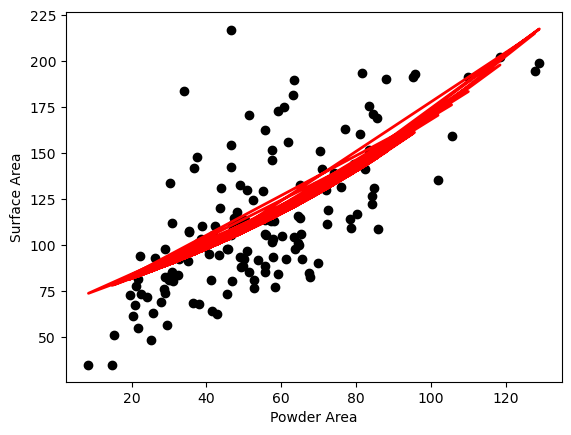

In [47]:
def plot_glm_results(result, x, y):
    # Plot the results
    fig, ax = plt.subplots()
    ax.scatter(x, y, color='black')
    ax.plot(x, result.fittedvalues, color='red', linewidth=2)
    ax.set_xlabel('Powder Area')
    ax.set_ylabel('Surface Area')
    plt.show()

plot_glm_results(result, sub_df['PowderArea'], sub_df['SurfaceArea'])

## 3.2 GLM to estimate raw intensity

Based on the mean RawIntD for each contact, it seems reasonable to run a GLM with log link function

In [ ]:
# create a GLM between PowderArea and SurfaceArea using Poisson distribution and log link function

# 4.0 Theoretical model for ABC-SMC

Define the analytical recursive model:

- Finger loading after $n$ contacts: $x_n = x_{n-1} (1 - \lambda)$ 
- Surface loading after $n$ contacst $y_n = \lambda  x_{n-1} A $

where $A$ is the powder area and $\lambda$ is the transfer efficiency.

In [5]:
def predict_luminescence(lambda_, x_prev, A):
    """
    Predict the luminescence on the surface after a contact.

    Parameters
    ----------
    lambda_ : float
        Transfer efficiency.
    x_prev : float  
        Amount of powder on the finger before the contact.
    A : float
        Surface area in contact with the surface (i.e. powder area not finger area)
    
    Returns
    -------
    y : float
        Predicted luminescence on the surface after the contact.
    x_next : float 
        Amount of powder on the finger after the contact.
    """
    y = lambda_ * x_prev * A
    x_next = x_prev * (1 - lambda_)
    return y, x_next




def model(param):
    """
    Model function for the piecewise solution.
    
    Parameters
    ----------
    param : tuple
        Tuple containing the values of the parameters A, x_init and lambda_.
        
    Returns
    -------
    C : array-like
        Array of luminescence values at the given contact.
    """
    x_prev = param['x_prev'] # initial amount of powder on the finger 
    A = param['A'] # powder area (not finger area)
    lambda_ = param['lambda_'] # transfer efficiency

    #t = measurement_times
    # Initialize empty array for concentration values
    #C = np.zeros_like(t)

    # Initialize the amount of powder on the finger before the first contact
    #x_prev = 100

    # Initialize empty array for concentration values
    C = [] #np.zeros_like(6)

    # Set the number of contacts
    num_contacts = 5

    # Iterate over the range of contacts
    for n in range(num_contacts):
        # Calculate the predicted luminescence on the surface and the amount of powder on the finger after the current contact
        y, x_prev = predict_luminescence(lambda_, x_prev, A)

        # Append the predicted luminescence to the list
        C.append(y)


    # Add noise to the simulated data
    sigma = 1E4
    C = np.array(C) + np.random.normal(sigma, sigma, size=len(C))
    

    return {"Concentration":C}




#model({"E":0.0001,"k":0.003851195,"lambda_":0.0001})['Concentration'].shape

#distance({"Concentration":measurement_data}, model({"E":10,"k":0.003851195,"lambda_":1.11}))


Define the true parameters (chosen by eye using a manual piece-wise curve fitting of the VMN_ad_08 file.)

In [6]:
A_true, x_prev_true, lambda_true = np.array([2, 25_880_980, 0.066])
#t1 = measurement_times[15:44]
#t1-np.min(t1)
model({"A": A_true, "x_prev": x_prev_true, "lambda_":lambda_true})

{'Concentration': array([3438045.1172646 , 3198066.68779856, 3000677.2033879 ,
        2798556.51077775, 2615817.62601096])}

Solve the model for the true parameter values and visualise the results

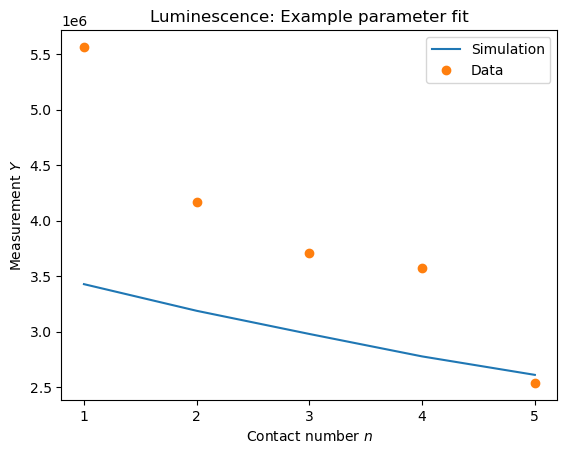

In [7]:
param = {'lambda_':lambda_true, 'x_prev':x_prev_true, 'A':A_true}
true_trajectory = model(param)["Concentration"]
plt.plot(measurement_times,true_trajectory, color="C0", label='Simulation')
#plt.plot(measurement_times, measurement_data, color="C1", label='Data')
#add error bars
#plt.errorbar(measurement_times, measurement_data, yerr=s, fmt='o', color="C1",label='Data')
plt.plot(measurement_times, measurement_data, 'o', color="C1",label='Data')
# plot on log scale
#plt.yscale('log')
plt.xlabel('Contact number $n$')
# make xticks integers
plt.xticks(np.arange(1, 6, 1.0))
plt.ylabel('Measurement $Y$')
plt.title('Luminescence: Example parameter fit')
plt.legend()
plt.show()

#np.array(model({'E':3.851195,'k':0.003,'lambda_':1.174})).max()

# 5.0 ABC-SMC

## 5.1 Define the distance function
We define the distance function as the sum of the squared differences between the model and the data. Note: we use PCMAD as the distance function in the paper.

In [ ]:
def distance(simulation, data):
    return np.absolute(data["Concentration"] - simulation["Concentration"]).sum()

Define the prior for $A$, $x_prev$, and $\lambda$

In [8]:
parameter_prior = Distribution(
    A=RV("uniform", 0.3, 2.5), x_prev=RV("uniform", 100_000, 55_000_000), lambda_=RV("uniform", 0, 0.3)
)
parameter_prior.get_parameter_names()

['A', 'lambda_', 'x_prev']

In [9]:
from pyabc.populationstrategy import AdaptivePopulationSize

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,
)

abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance_adaptive,
    population_size=1000,#AdaptivePopulationSize(500, 0.15),
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
    #eps=QuantileEpsilon(alpha=0.4)
    #transitions=LocalTransition(k_fraction=0.3),
    # eps=MedianEpsilon(500, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [10]:
abc.new(db_path, {"Concentration": np.array(measurement_data)})

ABC.History INFO: Start <ABCSMC id=2, start_time=2023-01-05 09:44:40>


In [11]:
h = abc.run(max_nr_populations=15) #

ABC INFO: Calibration sample t = -1.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 2.89418986e+00.
ABC INFO: Accepted: 1000 / 1981 = 5.0480e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.45824555e+00.
/Users/marcofking/opt/anaconda3/envs/clean_base/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/Users/marcofking/opt/anaconda3/envs/clean_base/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/Users/marcofking/opt/anaconda3/envs/clean_base/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/Users/marcofking/opt/anaconda3/envs/clean_base/lib/python3.8/site-packa

Visualization of the probability density functions for $A$, $x_{prev}$ and $\lambda$

KeyboardInterrupt: 

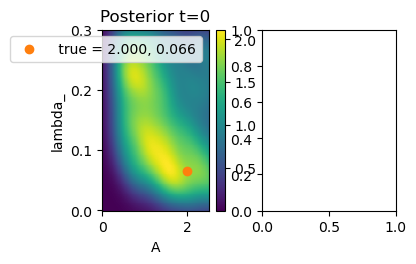

In [13]:
fig = plt.figure(figsize=(10, 8))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(3, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "A",
        "lambda_",
        xmin=0,
        xmax=2.5,
        numx=200,
        ymin=0,
        ymax=0.3,
        numy=200,
        ax=ax,
    )
    ax.scatter(
        [A_true],
        [lambda_true],
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            A_true, lambda_true
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

Plot marginal histograms of the posterior distributions of the three parameters

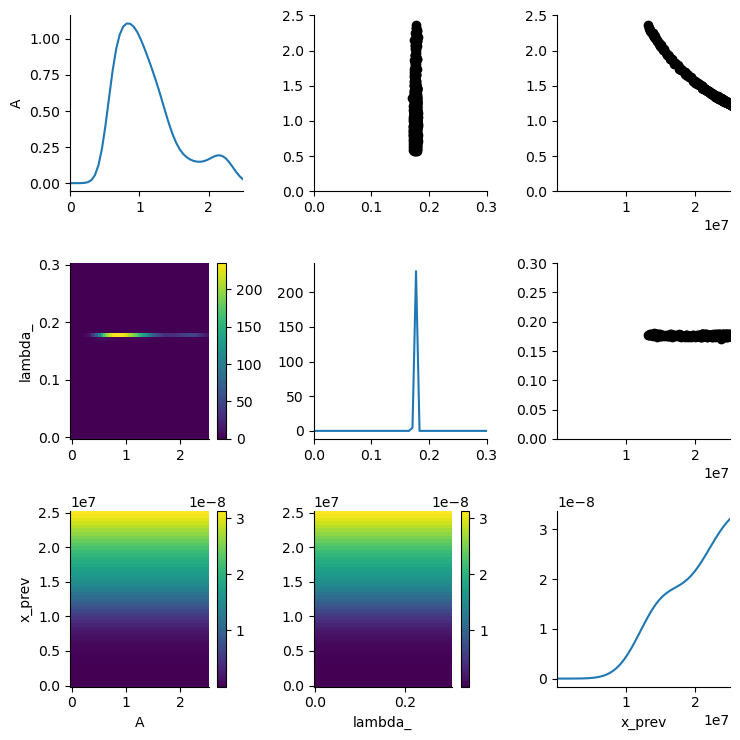

In [14]:
from pyabc.visualization import plot_kde_matrix

limits = dict(A=(0, 2.5), x_prev=(1E5, 25E6), lambda_=(0, .3))
df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

We can also plot the simulated trajectories:

<Figure size 1000x800 with 0 Axes>

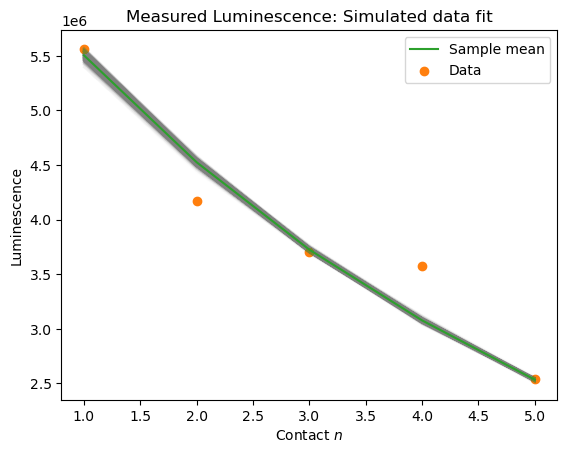

In [15]:
fig = plt.figure(figsize=(10, 8))
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Concentration'], color='grey', alpha=0.01)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Concentration'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(measurement_times,true_trajectory, color="C0", label='Initial guess')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Contact $n$')
plt.ylabel('Luminescence')
plt.title('Measured Luminescence: Simulated data fit')
plt.legend()
plt.show()

#save image
fig.savefig('luminescence_fit.png', dpi=300)


Summary table of parameters

In [126]:
# Create a summary table of parameter values
df, w = h.get_distribution(m=0, t=h.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
df = df.round(3)
df.describe()


name,A,lambda_,x_prev,w
count,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,0.765655,0.147645,5.238430e+07,0.001051
std,0.019610,0.001982,1.300207e+06,0.000220
min,0.719000,0.141000,5.001517e+07,0.001000
25%,0.751000,0.146000,5.130836e+07,0.001000
50%,0.766000,0.148000,5.234414e+07,0.001000
75%,0.780000,0.149000,5.340269e+07,0.001000
max,0.812000,0.153000,5.499701e+07,0.002000


# Compare against observed data

In [136]:
print('Median measured surface area is',round(sub_df['SurfaceArea'].median(),1)/100,'mm^2','but the median predicted surface area is',round(df['A'].median(),1),'mm^2')

Median measured surface area is 1.06 mm^2 but the median predicted surface area is 0.8 mm^2


## 6. Mixed effects model

The relationship between contact number and Luminescence appears linear.

In [16]:
#%pip install statsmodels
import statsmodels.formula.api as smf

# Split the data into a training and test set
train = data.sample(frac=0.8, random_state=1)
test = data.drop(train.index)

# Fit a mixed-effects model to the data
model = smf.mixedlm('RawIntD ~ ContactNumber + PowderArea + Gloves + Surface', train, groups='ID')
result = model.fit()

# Print the summary of the model fit
print(result.summary())


                       Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        RawIntD          
No. Observations:        1392           Method:                    REML             
No. Groups:              58             Scale:                     818009591808.1681
Min. group size:         19             Log-Likelihood:            -21041.8624      
Max. group size:         28             Converged:                 Yes              
Mean group size:         24.0                                                       
------------------------------------------------------------------------------------
                        Coef.        Std.Err.     z    P>|z|    [0.025      0.975]  
------------------------------------------------------------------------------------
Intercept               1194276.196 117293.972  10.182 0.000  964384.236 1424168.156
Gloves[T.Y]             -208613.588  49268.936  -4.234 0.000 -305178.928 -112048.249
Surf

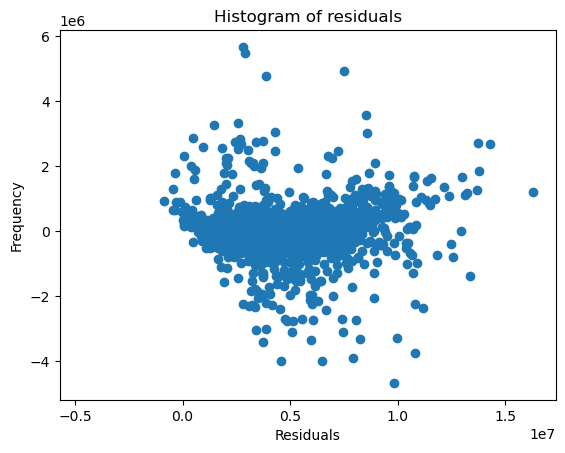

In [20]:
# plot the residuals
plt.scatter(result.fittedvalues, result.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')

# Analyze the residuals
plt.hist(result.resid, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of residuals')
plt.show()


Let's test the model on the test data set

Text(0.5, 1.0, 'Predicted vs. Actual values')

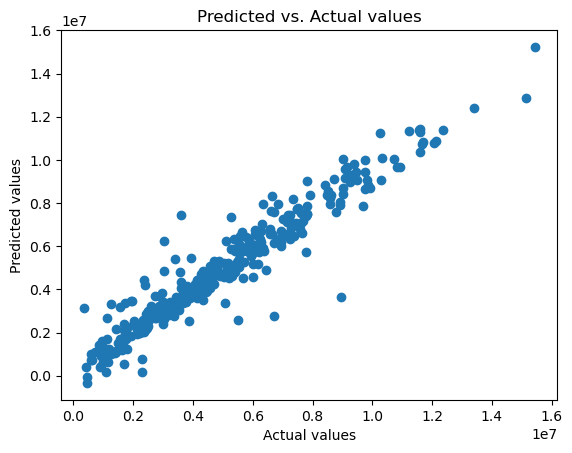

In [21]:
# Use hte model to predict the test set
pred = result.predict(test)

# Plot the predicted values against the actual values
plt.scatter(test['RawIntD'], pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values')


Text(0.5, 1.0, 'Bland-Altman plot')

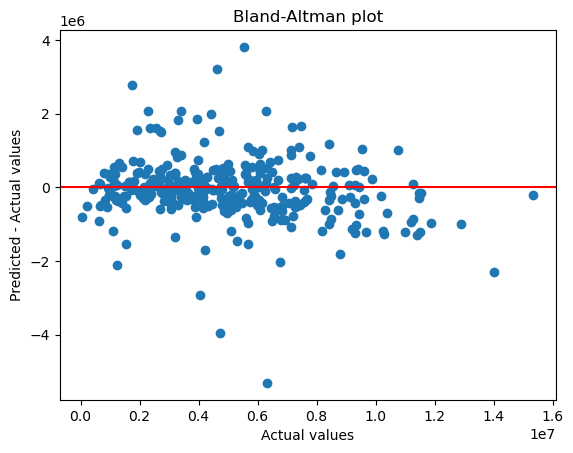

In [23]:
# plot Bland-Altman plot of the predicted vs actual values
plt.scatter((pred+test['RawIntD'])/2, pred - test['RawIntD'])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mean values')
plt.ylabel('Predicted - Actual values')
plt.title('Bland-Altman plot')


Use the coefficients of the model to predict transfer: coeff(PowderArea)/coeff(ContactNumber)

In [14]:
# calculate the transfer efficiency lambda using the coefficients from the model
lambda_ = result.params['PowderArea'] / result.params['ContactNumber']
lambda_

-0.7247660122589998